# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Кликкер для колаба, чтобы он не отваливался

In [ ]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

### Установка зависимостей

In [ ]:
# !pip install -U torch torchvision

In [ ]:
# # установка подходящей версии torch

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

8.4.0


<ipython-input-5-d9490079bb47>:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/Colab\ Notebooks/DLS\ Course/journey-springfield.zip -d train
!unzip -q /content/gdrive/MyDrive/Colab\ Notebooks/DLS\ Course/journey-springfield.zip -d test

In [ ]:
!ls train

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr  1 17:41:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from collections import Counter
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler
import torch.nn as nn
from torchsummary import summary

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy

In [ ]:
# !pip install torchsampler

In [ ]:
# from torchsampler import ImbalancedDatasetSampler

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
# DEVICE = torch.device("cuda")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# количество эпох обучения
EPOCHS = 30

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

#### Предобработка данных

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # image = Image.open(file)
        # image.load()
        image = cv2.imread(str(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # ])
        # x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        # x = transform(x)
        # if self.mode == 'test':
        #     return x
        # else:
        #     label = self.labels[index]
        #     label_id = self.label_encoder.transform([label])
        #     y = label_id.item()
        #     return x, y
        # train_transform = transforms.Compose([
        #     transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        #     # рассмотренные варианты
        #     # transforms.RandomHorizontalFlip(p=0.5),
        #     # transforms.RandomVerticalFlip(p=0.5),
        #     # transforms.ColorJitter(brightness=(0.1,0.6), contrast=1,saturation=0, hue=0.4),
        #     # transforms.RandomRotation(degrees=[*range(0, 181, 30)]),#list(range(0, 181, 30))
        #     # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #     # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #     # A.RandomBrightnessContrast(p=0.5),
        #     # A.GaussNoise(p=0.5),
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
        # ])
        # val_transform = transforms.Compose([
        #     transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
        # ])
        # if self.mode == 'train':
        #     x = train_transform(x)
        #     label = self.labels[index]
        #     label_id = self.label_encoder.transform([label])
        #     y = label_id.item()
        #     return x, y
        # elif self.mode == 'val':
        #     x = val_transform(x)
        #     label = self.labels[index]
        #     label_id = self.label_encoder.transform([label])
        #     y = label_id.item()
        #     return x, y
        # else:
        #     x = val_transform(x)
        #     return x

        train_transform = A.Compose([
            A.Resize(RESCALE_SIZE, RESCALE_SIZE),
            A.HorizontalFlip(p = 0.5),
            A.Compose([
                      A.Resize(256, 256), 
                      A.RandomCrop(RESCALE_SIZE, RESCALE_SIZE),
            ],p=0.5),
            A.OneOf([
                    A.RandomGamma(),
                    A.RandomBrightnessContrast(),
                ], p = 0.5),
            A.OneOf([
                    A.ElasticTransform(alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
                    A.GridDistortion(),
                    A.OpticalDistortion( distort_limit = 2, shift_limit = 0.5),
                ], p = 0.5),
            A.OneOf([
                    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15),
                    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
                ], p = 0.5),
            A.Rotate(),
            A.GaussNoise(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), 
            ToTensorV2(),
        ],p=1)

        val_transform = A.Compose([
            A.Resize(RESCALE_SIZE, RESCALE_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), 
            ToTensorV2(),
        ],p=1)

        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            augmented = train_transform(image=x)
            x = augmented['image']
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        elif self.mode == 'val':
            augmented = val_transform(image=x)
            x = augmented['image']
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            augmented = val_transform(image=x)
            x = augmented['image']
            return x

    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Сбалансируем классы с помощью семплера

In [ ]:
# # у класса Subset нет аттрибьюта targets
# # подсчитываем, сколько экземпляров каждого класса в train_dataset
# class_count = Counter(train_dataset_raw.targets[i] for i in train_idx) 

# class_weights = {i: 1/c for i, c in class_count.items()}
# sample_weights = [0] * len(train_dataset) # список из нулей длины len(train_dataset)
# for i, (data, label) in enumerate(tqdm(train_dataset)):
#     class_weight = class_weights[label]
#     sample_weights[i] = class_weight

# N = max(class_count.values()) * len(class_count)  # fit to max
# train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

Сбалансируем классы с помощью добавления картинок

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []
    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)
    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Дополним картинки классов у которых менее 150 картинок, до 150 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 150:
        dct_path_train[person] = dct_path_train[person] * (150 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:150 - len(dct_path_train[person])])

In [ ]:
new_train_files = []
for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])
new_train_label = [path.parent.name for path in new_train_files] # классы train

In [ ]:
# # определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# BATCH_SIZE = 128
# # DataLoader достаёт данные из dataset батчами
# dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
#                'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
# dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

In [ ]:
n_classes = len(np.unique(train_val_labels))

#### Давайте посмотрим на наших героев внутри датасета.

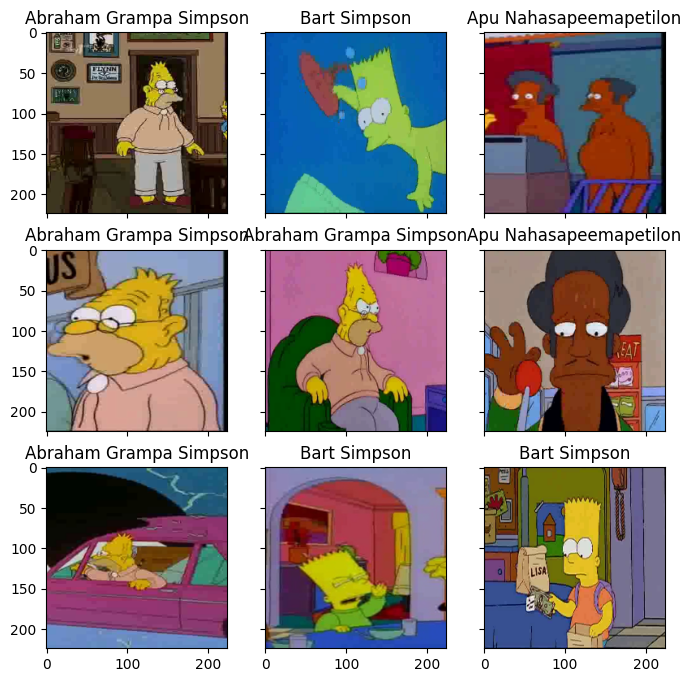

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


#### Бейзлайн модель

In [ ]:
# # Очень простая сеть
# class SimpleCnn(nn.Module):
  
#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

#### Vgg-16

In [ ]:
# model = models.vgg16(pretrained=True)

In [ ]:
# # Зафиксируем все веса модели теперь она необучаема
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# layers_to_unfreeze = 2

# # замораживаем параметры (веса)
# for param in model.classifier[:-layers_to_unfreeze].parameters():
#     param.requires_grad = False

In [ ]:
# feature_extract = True

In [ ]:
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False

In [ ]:
# set_parameter_requires_grad(model, feature_extract)

In [ ]:
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs,n_classes)

In [ ]:
# # посмотрим какие параметры нейросети мы учим
# params_to_update = model.parameters()
# print("Params to learn:")

# params_to_update = []
# for name,param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

In [ ]:
# # Заменяем родной классификатор vgg16 слой на наш линейный классификатор
# model.classifier = nn.Sequential(nn.Linear(25088, 128),
#                                  nn.Linear(128, classes_number))

#### ConvNext или EfficienctNet

In [ ]:
# model = models.convnext_base(pretrained=True)
# model = models.convnext_small(pretrained=True)
# model = models.convnext_tiny(pretrained=True)
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)#weights=EfficientNet_V2_S_Weights.DEFAULT
# model = models.efficientnet_v2_m(pretrained=True)

Замораживаем все веса кроме последнего слоя

In [ ]:
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False
# feature_extract = True
# set_parameter_requires_grad(model, feature_extract)
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs,n_classes)

Оставляем незамороженным классифайер и часть фичер экстрактора

In [ ]:
layers_to_unfreeze = 4
for param in model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
# for param in model.features.parameters():
#     param.requires_grad = False
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs,n_classes)

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.4.0.block.0.0.weight
	 features.4.0.block.0.1.weight
	 features.4.0.block.0.1.bias
	 features.4.0.block.1.0.weight
	 features.4.0.block.1.1.weight
	 features.4.0.block.1.1.bias
	 features.4.0.block.2.fc1.weight
	 features.4.0.block.2.fc1.bias
	 features.4.0.block.2.fc2.weight
	 features.4.0.block.2.fc2.bias
	 features.4.0.block.3.0.weight
	 features.4.0.block.3.1.weight
	 features.4.0.block.3.1.bias
	 features.4.1.block.0.0.weight
	 features.4.1.block.0.1.weight
	 features.4.1.block.0.1.bias
	 features.4.1.block.1.0.weight
	 features.4.1.block.1.1.weight
	 features.4.1.block.1.1.bias
	 features.4.1.block.2.fc1.weight
	 features.4.1.block.2.fc1.bias
	 features.4.1.block.2.fc2.weight
	 features.4.1.block.2.fc2.bias
	 features.4.1.block.3.0.weight
	 features.4.1.block.3.1.weight
	 features.4.1.block.3.1.bias
	 features.4.2.block.0.0.weight
	 features.4.2.block.0.1.weight
	 features.4.2.block.0.1.bias
	 features.4.2.block.1.0.weight
	 features.4.2.block.1.1.weig

#### Обучение

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_exp, scheduler_step):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler_exp.step()
    scheduler_step.step()         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, opt, scheduler_exp, scheduler_step, epoch=0):
    torch.cuda.empty_cache()
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, sampler=ImbalancedDatasetSampler(train_dataset)
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs-epoch) as pbar_outer:
        opt = opt
        criterion = nn.CrossEntropyLoss()
        scheduler_exp = scheduler_exp
        scheduler_step = scheduler_step
        # opt = torch.optim.AdamW([
        #         {'params': model.features.parameters(), 'lr': 1e-4},
        #         {'params': model.classifier.parameters(), 'lr': 1e-4}
        #     ])
        # criterion = nn.CrossEntropyLoss()
        # scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
        # scheduler_step = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
        # разбираюсь с планировщиками
        # scheduler = ConstantLR(self.opt, factor=0.1, total_iters=2)
        # scheduler = CosineAnnealingLR(optimizer,last_epoch=3)
        # scheduler = LinearLR(opt, start_factor=2, total_iters=3)
        # scheduler = SequentialLR(opt, schedulers=[scheduler1, scheduler2], milestones=[3])
        # scheduler = ChainedScheduler([scheduler_exp, scheduler_step])
        # scheduler = ReduceLROnPlateau(opt, 'min', patience = 5)
        # scheduler = OneCycleLR(opt, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=EPOCHS)
        
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(epoch, epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler_exp, scheduler_step)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            torch.save({
                        'epoch': epoch,
                        'model_state_dict': best_model_wts,
                        'optimizer_state_dict': opt.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'scheduler_exp': scheduler_exp.state_dict(),
                        'scheduler_step': scheduler_step.state_dict(),
                        }, F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_check1.pth")
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
    model.load_state_dict(best_model_wts)       
    torch.cuda.empty_cache()
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Отправим модель на дообучение с последнего чекпоинта

In [ ]:
# model = model()
opt = torch.optim.AdamW([
                {'params': model.features.parameters(), 'lr': 1e-4},
                {'params': model.classifier.parameters(), 'lr': 1e-4}
                ])
scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
scheduler_step = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

checkpoint = torch.load(F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_check1.pth")
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_exp.load_state_dict(checkpoint['scheduler_exp'])
scheduler_step.load_state_dict(checkpoint['scheduler_step'])
epoch = checkpoint['epoch']+1
# loss = checkpoint['loss']

# model.eval()

In [ ]:
# model = model.half()     # convert a model to 16-bit
# input = input.half()     # convert a model to 16-bit

In [ ]:
# n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
cnn = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(simple_cnn)
# print(cnn)

we will classify :42


#### Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
# train_dataset = SimpsonsDataset(train_files, mode='train')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
# history = train(train_dataset, val_dataset, model=cnn, epochs=EPOCHS, batch_size=128)
history = train(new_train_dataset, val_dataset, model=cnn, epochs=EPOCHS, batch_size=128, opt=opt, scheduler_exp=scheduler_exp, scheduler_step=scheduler_step, epoch=epoch)
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.29114634257358196


epoch:   3%|▎         | 1/30 [06:26<3:06:49, 386.55s/it]


Epoch 020 train_loss: 0.2911     val_loss 0.0953 train_acc 0.9641 val_acc 0.9906
loss 0.13947722964016576


epoch:   7%|▋         | 2/30 [12:43<2:57:45, 380.92s/it]


Epoch 021 train_loss: 0.1395     val_loss 0.0574 train_acc 0.9769 val_acc 0.9918
loss 0.10657184029585987


epoch:  10%|█         | 3/30 [18:58<2:50:15, 378.34s/it]


Epoch 022 train_loss: 0.1066     val_loss 0.0474 train_acc 0.9792 val_acc 0.9927
loss 0.0928752948062516


epoch:  13%|█▎        | 4/30 [25:14<2:43:26, 377.16s/it]


Epoch 023 train_loss: 0.0929     val_loss 0.0427 train_acc 0.9800 val_acc 0.9929
loss 0.09014444999482678


epoch:  17%|█▋        | 5/30 [31:29<2:36:51, 376.44s/it]


Epoch 024 train_loss: 0.0901     val_loss 0.0399 train_acc 0.9802 val_acc 0.9929
loss 0.08294296653046096


epoch:  20%|██        | 6/30 [37:42<2:30:05, 375.22s/it]


Epoch 025 train_loss: 0.0829     val_loss 0.0381 train_acc 0.9820 val_acc 0.9929
loss 0.08201282609506567


epoch:  23%|██▎       | 7/30 [43:55<2:23:34, 374.53s/it]


Epoch 026 train_loss: 0.0820     val_loss 0.0366 train_acc 0.9799 val_acc 0.9927
loss 0.07775344271188961


epoch:  27%|██▋       | 8/30 [50:08<2:17:07, 373.97s/it]


Epoch 027 train_loss: 0.0778     val_loss 0.0356 train_acc 0.9808 val_acc 0.9925
loss 0.07688682462097632


epoch:  30%|███       | 9/30 [56:22<2:10:56, 374.10s/it]


Epoch 028 train_loss: 0.0769     val_loss 0.0349 train_acc 0.9810 val_acc 0.9927
loss 0.07461667069605726


epoch:  33%|███▎      | 10/30 [1:02:38<2:04:54, 374.73s/it]


Epoch 029 train_loss: 0.0746     val_loss 0.0342 train_acc 0.9817 val_acc 0.9929
loss 0.07132820124329846


epoch:  37%|███▋      | 11/30 [1:08:53<1:59:00, 375.80s/it]



Epoch 030 train_loss: 0.0713     val_loss 0.0336 train_acc 0.9828 val_acc 0.9929


In [ ]:
# сохранить веса нашей нейросети model
torch.save(model.state_dict(), F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_weights1.pth") 
# torch.save(cnn.state_dict(), F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_weights1.pth") 

In [ ]:
# import copy
# # сохранить веса нашей нейросети model
# model_weights = copy.deepcopy(model.state_dict())
# torch.save(model_weights, "path_to\\model_wights.pth") 

In [ ]:
# # загружаем сохраненное состояние весов нейросети
# model.load_state_dict(torch.load("path_to\\model_wights.pth"))
# model.eval()# переключаем нейросеть в режим обучения

In [ ]:
# model = model()
# opt = torch.optim.AdamW([
#                 {'params': model.features.parameters(), 'lr': 1e-4},
#                 {'params': model.classifier.parameters(), 'lr': 1e-4}
#             ])

# checkpoint = torch.load(F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_check.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

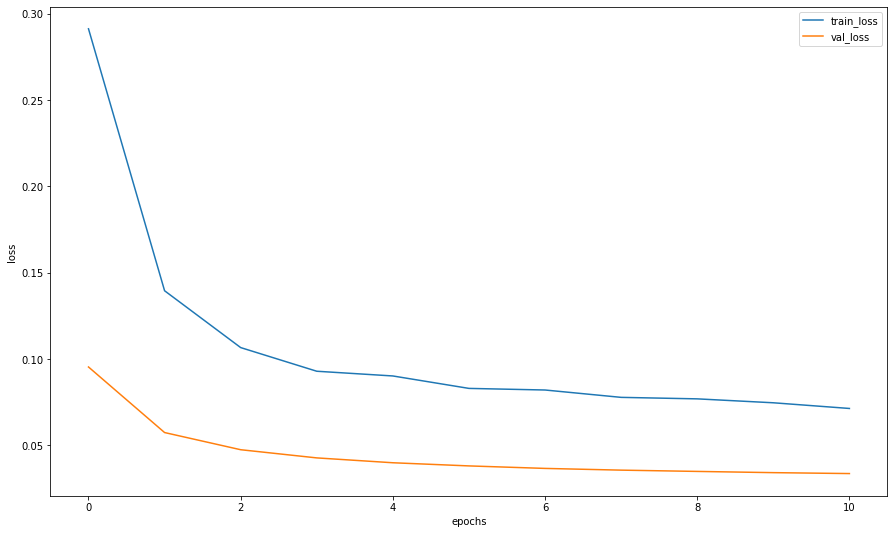

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Загрузим модель с лучшими весами и проверим ее

In [ ]:
checkpoint = torch.load(F"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/eff_model_check1.pth")
model.load_state_dict(checkpoint['model_state_dict'])
cnn = model.to(DEVICE)

cnn.eval();

#### Определение скорости обучения

In [ ]:
# import math
# def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
#     """Слегка модифицированная функция для поиска оптимального learning rate 
#     функция взята из замечатлеьной книги книги "Ian Pointer - Programming PyTorch
#     for Deep Learning - Creating and Deploying Deep Learning Applications-
#     O’Reilly Media (2019)
#     """
#     model.train()
#     number_in_epoch = len(dataloaders['train']) - 1
#     update_step = (final_value / init_value) ** (1 / number_in_epoch)
#     lr = init_value
#     optimizer.param_groups[0]["lr"] = lr
#     best_loss = 0.0
#     batch_num = 0
#     losses = []
#     log_lrs = []
#     for inputs, labels in dataloaders['train']:
#         if use_gpu:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#         batch_num += 1
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)

#         # Crash out if loss explodes

#         if batch_num > 1 and loss > 4 * best_loss:
#             return log_lrs[10:-5], losses[10:-5]

#         # Record the best loss

#         if loss < best_loss or batch_num == 1:
#             best_loss = loss

#         # Store the values

#         losses.append(loss)
#         log_lrs.append(math.log10(lr))

#         # Do the backward pass and optimize

#         loss.backward()
#         optimizer.step()

#         # Update the lr for the next step and store

#         lr *= update_step
#         optimizer.param_groups[0]["lr"] = lr
#     return log_lrs[10:-5], losses[10:-5]

In [ ]:
# # Создаём сеть
# model_vgg16_bn = models.vgg16_bn(pretrained=True)

In [ ]:
# for param in model_vgg16_bn.parameters():
#     param.requires_grad = False

# for param in model_vgg16_bn.classifier.parameters():
#     param.requires_grad = True

In [ ]:
# # В качестве cost function используем кросс-энтропию
# loss_fn = nn.CrossEntropyLoss()

# # В качестве оптимизатора AdaShift из репозитория МФТИ
# optimizer = torch.optim.AdamW(model_vgg16_bn.classifier.parameters(), lr=1e-3, amsgrad=True)

# # Использовать ли GPU
# model_vgg16_bn = model_vgg16_bn.cuda()

In [ ]:
# # подбор оптимального lr для классификатора model_vgg16_bn.classifier
# logs, losses = find_lr(model_vgg16_bn, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

In [ ]:
# # построим график для оптимального подбора lr
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)
# ax.plot(logs,losses)
# ax.set_xlabel("$10^x$")
# ax.set_ylabel("loss")

In [ ]:
# param512 = model_vgg16_bn.features[27:44].parameters()
# param256 = model_vgg16_bn.features[17:27].parameters()
# param128 = model_vgg16_bn.features[10:17].parameters()
# param64 = model_vgg16_bn.features[0:10].parameters()

In [ ]:
# # В качестве cost function используем кросс-энтропию
# loss_fn = nn.CrossEntropyLoss()

# found_lr = lr=1e-3

# # Дифференциальное обучение (по группам слоев)у каждой группы свой lr

# optimizer = torch.optim.AdamW([
# { 'params': model_vgg16_bn.classifier.parameters(), 'lr': found_lr},
# { 'params': param512, 'lr': found_lr / 3},
# { 'params': param256, 'lr': found_lr / 10},
# { 'params': param128, 'lr': found_lr / 50},
# { 'params': param64, 'lr': found_lr / 100},
# ], lr=found_lr / 100, amsgrad=True)

# # Использовать ли GPU
# model_vgg16_bn = model_vgg16_bn.cuda()

#### Сonfusion matrix

In [ ]:
# import itertools
# from sklearn.metrics import confusion_matrix
    
# # Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# # Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     cm = cm.T
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     #print(cm)
#     plt.figure(figsize=(16,11))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

#     plt.tight_layout()
    
# def show_confusion_matrix_fucn(model):
#     """Построить и посчитать точность классов по confusion matrix"""
#     y_test_all = torch.Tensor().long()
#     predictions_all = torch.Tensor().long()

#     # Пройдём по всему validation датасету и запишем ответы сети
#     with torch.no_grad():
#         for inputs, labels in dataloaders['val']:
#             predictions = model(inputs.to(DEVICE))
#             y_test = labels
#             _, predictions = torch.max(predictions.cpu(), 1)

#             # Аналог append для list
#             y_test_all = torch.cat((y_test_all, y_test), 0)
#             predictions_all = torch.cat((predictions_all, predictions), 0)

#     feature_names = sorted(set(dataloaders['val'].dataset.labels))

#     y_test_all = y_test_all.numpy()
#     predictions_all = predictions_all.numpy()

#     # Функция из sklearn, создаёт confusion матрицу
#     cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
#     # Выведем её
#     plot_confusion_matrix(cm, feature_names, normalize=True)
    
#     return y_test_all, predictions_all
  
# def accurancy_for_each_class(y_test_all, predictions_all):
#     class_correct = [0 for i in range(classes_number)]
#     class_total = [0 for i in range(classes_number)]
#     feature_names = sorted(set(dataloaders['val'].dataset.labels))

#     c = (predictions_all == y_test_all).squeeze()
#     for i in range(len(predictions_all)):
#         label = predictions_all[i]            
#         class_correct[label] += c[i].item()
#         class_total[label] += 1

#     print(class_total)
#     print(len(class_total))

#     for i in range(classes_number):
#         print('Accuracy of %5s : %2d %%' % (
#             (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
# TRAIN_DIR = Path('dataset/train')
# TEST_DIR = Path('dataset/testset')

# train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# from sklearn.model_selection import train_test_split

# train_val_labels = [path.parent.name for path in train_val_files]
# train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
#                                           stratify=train_val_labels)

# val_dataset = SimpsonsDataset(val_files, mode='val')
# train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# BATCH_SIZE = 128
# # DataLoader достаёт данные из dataset батчами
# dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
#                'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
# dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

In [ ]:
# # Построим confusion_matrix
# y_test_all, predictions_all = show_confusion_matrix_fucn(model)

In [ ]:
# # Выведем точность для каждого класса
# accurancy_for_each_class(y_test_all, predictions_all)

#### Ансамбль

In [ ]:
# class MyEnsemble(nn.Module):   
#     def __init__(self, modelA, modelB):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.classifier = nn.Linear(classes_number * 2, classes_number)
        
#     def forward(self, x):
#         x1 = self.modelA(x)
#         x2 = self.modelB(x)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.classifier(x)
#         return x

In [ ]:
# # Зададим путь для загрузки моделей!
# path_vgg16_bn = '/путь_до_весов_модели/vgg16_bn.pth'
# path_resnet50 = '/путь_до_весов_модели/resnet50.pth'

In [ ]:
# # Загружаем state dicts
# model_vgg16_bn.load_state_dict(torch.load(path_vgg16_bn))
# model_resnet50.load_state_dict(torch.load(path_resnet50))

In [ ]:
# model_ensemble = MyEnsemble(model_vgg16_bn, model_resnet50)

In [ ]:
# # замораживаем параметры (веса) не входящие в layers_to_unfreeze
# for param in model_ensemble.parameters():
#     param.requires_grad = False

# for param in model_ensemble.classifier.parameters():
#     param.requires_grad = True

In [ ]:
# # посмотрим какие параметры учим у model_ensemble
# print_learn_params(model_ensemble)

# Params to learn:
# 	 classifier.weight
# 	 classifier.bias

#### Использование RandomWeightSampler

In [ ]:
# # посчитаем веса
# dct_simpsons_wht = {}
# for key in dct_simpsons:
#     dct_simpsons_wht.update({key:1. / dct_simpsons[key]})

In [ ]:
# samples_train_weight = count_weights_from_labels(train_labels, dct_simpsons_wht)
# sampler_train_wht = torch.utils.data.WeightedRandomSampler(samples_train_weight, len(samples_train_weight))

# samples_val_weight = count_weights_from_labels(val_labels, dct_simpsons_wht)
# sampler_val_wht = torch.utils.data.WeightedRandomSampler(samples_val_weight, len(samples_val_weight))

# # определим загрузщики данных с взвешиванием классов для их балансировки WeightedRandomSampler
# BATCH_SIZE = 128
# # DataLoader достаёт данные из dataset батчами
# dataloaders_wht = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler_train_wht),
#                'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=sampler_val_wht)}
# dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

Более правильный вариант из https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

In [ ]:
# class_counts = imbalanced_train_df.label.value_counts(); class_counts

In [ ]:
# class_weights = 1/class_counts; class_weights

In [ ]:
# sample_weights = [1/class_counts[i] for i in imbalanced_train_df.label.values]

In [ ]:
# from torch.utils.data import WeightedRandomSampler

# sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(ds), replacement=True)
# dl = DataLoader(ds, sampler=sampler, batch_size=10)

In [ ]:
# # Oversample the minority classes
# targets = dataset.train_labels
# class_count = np.unique(targets, return_counts=True)[1]
# print(class_count)

# weight = 1. / class_count
# samples_weight = weight[targets]
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(cnn, ex_img.unsqueeze(0))
# probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(cnn, imgs)
# probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, y_pred, average='macro')
# f1_score(actual_labels, y_pred, average='weighted')
f1_score(actual_labels, y_pred, average='micro')
# f1_score(actual_labels, preds_class)


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

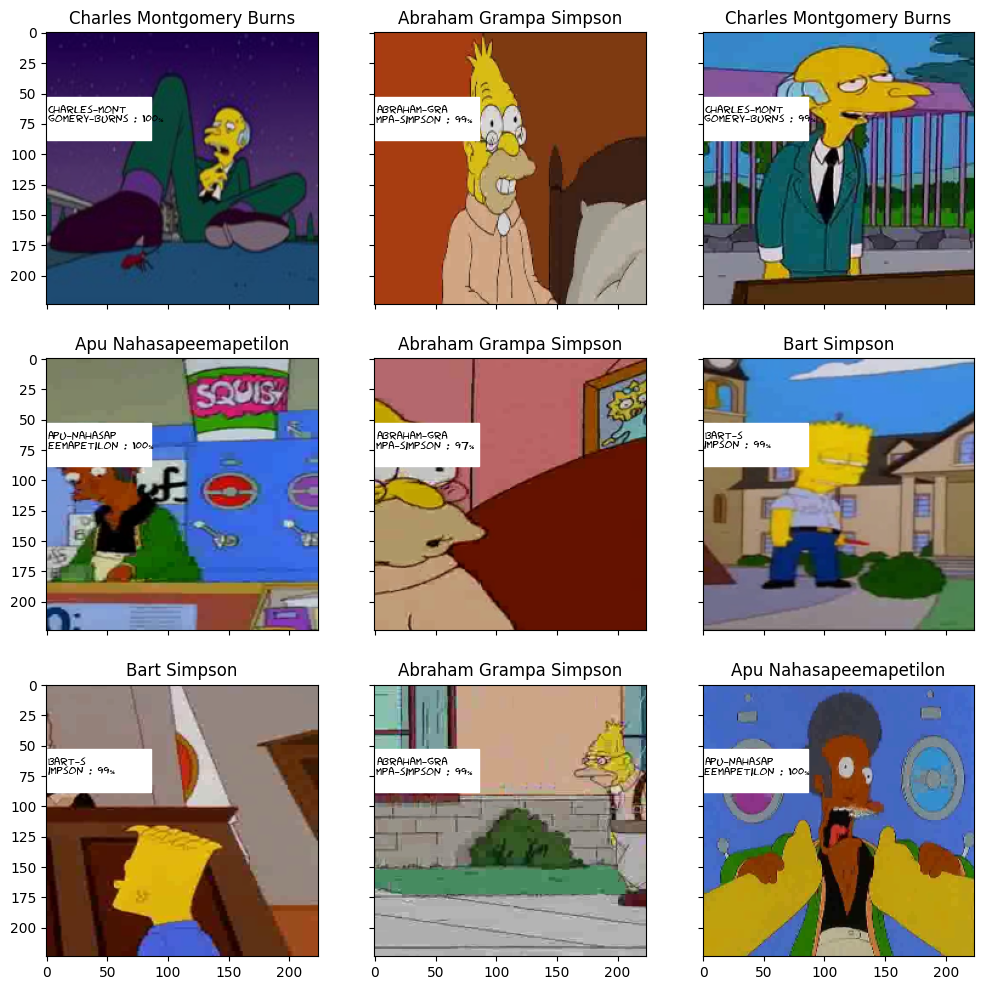

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(cnn, im_val.unsqueeze(0))
    # prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(cnn, test_loader)
# probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
!ls train

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
import pandas as pd
my_submit = pd.read_csv("train/sample_submission.csv")
# my_submit = pd.read_csv("gdrive/MyDrive/sample_submission.csv")
# my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/MyDrive/Colab Notebooks/DLS Course/cnn_baseline.csv', index=False)
# my_submit.to_csv('gdrive/MyDrive/simpsons/simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
